In [59]:
import pandas as pd
import numpy as np
import os
import joblib
import matplotlib.pyplot as plt
import seaborn as sns
import warnings
from sklearn.model_selection import train_test_split, GridSearchCV
from sklearn.preprocessing import StandardScaler, LabelEncoder
from sklearn.pipeline import Pipeline
from sklearn.linear_model import LogisticRegression
from sklearn.ensemble import RandomForestClassifier
from sklearn.svm import SVC
from sklearn.metrics import classification_report, ConfusionMatrixDisplay, accuracy_score,f1_score
from imblearn.over_sampling import SMOTE 

# Tắt các cảnh báo không quan trọng
warnings.filterwarnings('ignore')

print("--- Bắt đầu Script 2: Huấn luyện Mô hình Biceps Curl ---")
print("Đã nạp tất cả thư viện...")

--- Bắt đầu Script 2: Huấn luyện Mô hình Biceps Curl ---
Đã nạp tất cả thư viện...


In [60]:
# Định nghĩa các tệp đầu vào (do Notebook 1 tạo ra) và tệp đầu ra (mô hình .joblib)
# Giả sử script này chạy từ thư mục gốc (cùng cấp với 'notebooks', 'models')

INPUT_CSV_FRAMES = 'bicep_curl_all_frames_data.csv'
INPUT_CSV_LABELS = 'bicep_curl_AUTOLABELED_reps.csv'
MODEL_OUTPUT_DIR = os.path.join('models', 'classification_model')
MODEL_OUTPUT_PATH = os.path.join(MODEL_OUTPUT_DIR, 'bicep_curl_best_model.joblib')

# Đảm bảo thư mục model tồn tại
os.makedirs(MODEL_OUTPUT_DIR, exist_ok=True)

In [61]:
# Đọc cả hai tệp CSV: một tệp chứa dữ liệu landmarks thô của các frame,
# và một tệp chứa nhãn 'Correct'/'Incorrect' cho từng rep.

if not os.path.exists(INPUT_CSV_FRAMES) or not os.path.exists(INPUT_CSV_LABELS):
    print(f"LỖI: Không tìm thấy tệp đầu vào.")
    print(f"Hãy đảm bảo 2 tệp sau tồn tại trong thư mục 'notebooks/':")
    print(f"1. bicep_curl_all_frames_data.csv")
    print(f"2. bicep_curl_AUTOLABELED_reps.csv")
    print("Vui lòng chạy Notebook 1 trước.")
    exit()
    
print(f"Đọc dữ liệu landmarks từ: {INPUT_CSV_FRAMES}")
df_frames = pd.read_csv(INPUT_CSV_FRAMES)

print(f"Đọc nhãn (labels) từ: {INPUT_CSV_LABELS}")
df_labels = pd.read_csv(INPUT_CSV_LABELS)

Đọc dữ liệu landmarks từ: bicep_curl_all_frames_data.csv
Đọc nhãn (labels) từ: bicep_curl_AUTOLABELED_reps.csv


In [62]:
# Đây là bước quan trọng nhất. Chúng ta biến đổi dữ liệu thô (7135 frames)
# thành dữ liệu theo rep (104 reps).
# Chúng ta tính 'mean', 'std', 'min', 'max' cho mỗi landmark trên mỗi rep.

print("Đang tổng hợp đặc trưng (features) cho mỗi rep...")

# Lọc bỏ các frame không thuộc rep nào (rep_id == 0)
df_reps_data = df_frames[df_frames['rep_id'] > 0].copy()

# Lấy tất cả các cột landmark 'lm_'
feature_columns = [col for col in df_frames.columns if col.startswith('lm_')]
print(f"Sử dụng {len(feature_columns)} cột đặc trưng (landmarks).")

# Định nghĩa các phép tổng hợp
agg_funcs = ['mean', 'std', 'min', 'max']
agg_dict = {col: agg_funcs for col in feature_columns}

# Nhóm theo (video_id, rep_id) và tổng hợp
df_agg = df_reps_data.groupby(['video_id', 'rep_id']).agg(agg_dict)

# Sửa lại tên cột (ví dụ: 'lm_0_x_mean', 'lm_0_x_std', ...)
df_agg.columns = ['_'.join(col).strip() for col in df_agg.columns.values]
df_agg = df_agg.reset_index()

print(f"Đã tổng hợp {len(df_agg)} reps.")

Đang tổng hợp đặc trưng (features) cho mỗi rep...
Sử dụng 132 cột đặc trưng (landmarks).
Đã tổng hợp 104 reps.


In [63]:
# Gộp 2 bảng lại: bảng đặc trưng (df_agg) và bảng nhãn (df_labels)
# dựa trên 'video_id' và 'rep_id' để đảm bảo chúng khớp nhau.

print("Đang gộp đặc trưng và nhãn...")
final_data = pd.merge(df_agg, df_labels, on=['video_id', 'rep_id'], how='inner')

if len(final_data) != len(df_labels):
    print(f"Cảnh báo: Số lượng rep không khớp! (Features: {len(df_agg)}, Labels: {len(df_labels)})")

# Xử lý NaNs (nếu rep chỉ có 1 frame, 'std' sẽ là NaN)
final_data = final_data.fillna(0)


Đang gộp đặc trưng và nhãn...


In [64]:
# Tách X (features) và y (labels) ra.
# Mã hóa 'Correct' -> 0 và 'Incorrect' -> 1.

print("Chuẩn bị dữ liệu cho mô hình...")
y_labels = final_data['rep_label']
X = final_data.drop(columns=['video_id', 'rep_id', 'rep_label'])

# Mã hóa Nhãn
encoder = LabelEncoder()
y = encoder.fit_transform(y_labels)

# encoder.classes_ sẽ là ['Correct', 'Incorrect']
# y sẽ là [0, 1, 1, 0, ...]
print(f"Đã mã hóa nhãn: {list(encoder.classes_)} -> {list(range(len(encoder.classes_)))}")
print(f"Tổng số rep (samples): {len(X)}")
print(f"Tổng số đặc trưng (features) sau khi tổng hợp: {len(X.columns)}")


Chuẩn bị dữ liệu cho mô hình...
Đã mã hóa nhãn: ['Correct', 'Incorrect'] -> [0, 1]
Tổng số rep (samples): 104
Tổng số đặc trưng (features) sau khi tổng hợp: 528


In [65]:
# Chia dữ liệu thành 80% huấn luyện và 20% kiểm tra.
# 'stratify=y' là rất quan trọng để giữ tỷ lệ Đúng/Sai trong cả hai tập.

print("Phân chia dữ liệu Train/Test (80/20)...")
X_train, X_test, y_train, y_test = train_test_split(
    X, y, 
    test_size=0.2, 
    random_state=42, 
    stratify=y
)

print(f"Kích thước tập Train: {X_train.shape}")
print(f"Kích thước tập Test: {X_test.shape}")
print("Phân phối nhãn (0=Correct, 1=Incorrect) trong tập Test:")
print(pd.Series(y_test).value_counts())

Phân chia dữ liệu Train/Test (80/20)...
Kích thước tập Train: (83, 528)
Kích thước tập Test: (21, 528)
Phân phối nhãn (0=Correct, 1=Incorrect) trong tập Test:
1    14
0     7
Name: count, dtype: int64


In [66]:
# Dữ liệu của bạn bị mất cân bằng (35 Đúng vs 69 Sai).
# Chúng ta *chỉ* cân bằng tập huấn luyện (train data) để mô hình học tốt hơn.

print("\nCân bằng tập Train bằng SMOTE...")
smote = SMOTE(random_state=42)
try:
    X_train_res, y_train_res = smote.fit_resample(X_train, y_train)
    print("--- Phân phối Nhãn SAU KHI cân bằng (Tập Train) ---")
    print(pd.Series(y_train_res).value_counts())
except ValueError as e:
    print(f"Cảnh báo SMOTE: {e}. Có thể số lượng mẫu quá ít.")
    print("Tiếp tục mà không dùng SMOTE.")
    X_train_res, y_train_res = X_train, y_train




Cân bằng tập Train bằng SMOTE...
--- Phân phối Nhãn SAU KHI cân bằng (Tập Train) ---
0    55
1    55
Name: count, dtype: int64


In [67]:
# Thiết lập 3 mô hình để so sánh.
# Mỗi mô hình nằm trong một 'Pipeline' (Quy trình):
# 1. StandardScaler: Chuẩn hóa dữ liệu (rất quan trọng cho SVM/LogReg).
# 2. Classifier: Chạy mô hình (ví dụ: RandomForest).
# GridSearchCV sẽ tự động tìm các tham số tốt nhất.

print("\n--- Bắt đầu Huấn luyện & Tinh chỉnh Mô hình ---")

# 1. Logistic Regression
pipe_lr = Pipeline([
    ('scaler', StandardScaler()),
    ('clf', LogisticRegression(max_iter=1000, random_state=42))
])
params_lr = {
    'clf__C': [0.1, 1.0, 10],
    'clf__solver': ['liblinear']
}

# 2. Random Forest
pipe_rf = Pipeline([
    ('scaler', StandardScaler()),
    ('clf', RandomForestClassifier(random_state=42))
])
params_rf = {
    'clf__n_estimators': [50, 100],
    'clf__max_depth': [5, 10, None]
}

# 3. SVM (Support Vector Machine)
pipe_svm = Pipeline([
    ('scaler', StandardScaler()),
    ('clf', SVC(probability=True, random_state=42))
])
params_svm = {
    'clf__C': [0.1, 1.0, 10],
    'clf__kernel': ['rbf', 'linear']
}

# Danh sách các mô hình để chạy
models_to_tune = [
    ('LogisticRegression', pipe_lr, params_lr),
    ('RandomForest', pipe_rf, params_rf),
    ('SVM', pipe_svm, params_svm)
]

best_estimators = {}
best_score = 0.0
best_model_name = ""



--- Bắt đầu Huấn luyện & Tinh chỉnh Mô hình ---


In [68]:
best_estimators = {}
model_results = [] # DANH SÁCH MỚI ĐỂ LƯU KẾT QUẢ
best_f1_score = 0.0 # Sửa: Dùng F1-score để chọn
best_model_name = ""

for name, pipeline, params in models_to_tune:
    print(f"\n--- Đang tinh chỉnh: {name} ---")
    # Sửa: Dùng 'f1_weighted' làm điểm chính để so sánh, vì dữ liệu mất cân bằng
    grid_search = GridSearchCV(pipeline, params, cv=3, scoring='f1_weighted', n_jobs=-1, verbose=1)
    
    grid_search.fit(X_train_res, y_train_res)
    
    best_estimator = grid_search.best_estimator_
    best_estimators[name] = best_estimator
    
    print(f"Tham số tốt nhất: {grid_search.best_params_}")
    print(f"Điểm F1 tốt nhất (trên tập train/val): {grid_search.best_score_:.4f}")
    
    # Đánh giá trên tập Test (Dữ liệu GỐC, không cân bằng)
    y_pred = best_estimator.predict(X_test)
    test_accuracy = accuracy_score(y_test, y_pred)
    test_f1 = f1_score(y_test, y_pred, average='weighted') # Tính F1-score
    
    print(f"Độ chính xác trên TẬP TEST (gốc): {test_accuracy:.4f}")
    print(f"F1-score (weighted) trên TẬP TEST (gốc): {test_f1:.4f}")
    
    # Lưu kết quả để vẽ
    model_results.append({
        'name': name,
        'accuracy': test_accuracy,
        'f1_weighted': test_f1
    })
    
    # Cập nhật mô hình tốt nhất (dựa trên F1-score)
    if test_f1 > best_f1_score:
        best_f1_score = test_f1
        best_model_name = name

print("\n--- HOÀN TẤT HUẤN LUYỆN ---")


--- Đang tinh chỉnh: LogisticRegression ---
Fitting 3 folds for each of 3 candidates, totalling 9 fits
Tham số tốt nhất: {'clf__C': 1.0, 'clf__solver': 'liblinear'}
Điểm F1 tốt nhất (trên tập train/val): 0.8713
Độ chính xác trên TẬP TEST (gốc): 0.7143
F1-score (weighted) trên TẬP TEST (gốc): 0.7182

--- Đang tinh chỉnh: RandomForest ---
Fitting 3 folds for each of 6 candidates, totalling 18 fits
Tham số tốt nhất: {'clf__max_depth': 5, 'clf__n_estimators': 50}
Điểm F1 tốt nhất (trên tập train/val): 0.8176
Độ chính xác trên TẬP TEST (gốc): 0.7619
F1-score (weighted) trên TẬP TEST (gốc): 0.7674

--- Đang tinh chỉnh: SVM ---
Fitting 3 folds for each of 6 candidates, totalling 18 fits
Tham số tốt nhất: {'clf__C': 1.0, 'clf__kernel': 'linear'}
Điểm F1 tốt nhất (trên tập train/val): 0.8625
Độ chính xác trên TẬP TEST (gốc): 0.7619
F1-score (weighted) trên TẬP TEST (gốc): 0.7674

--- HOÀN TẤT HUẤN LUYỆN ---



--- Biểu Đồ So Sánh Hiệu Suất Mô Hình (trên Tập Test) ---


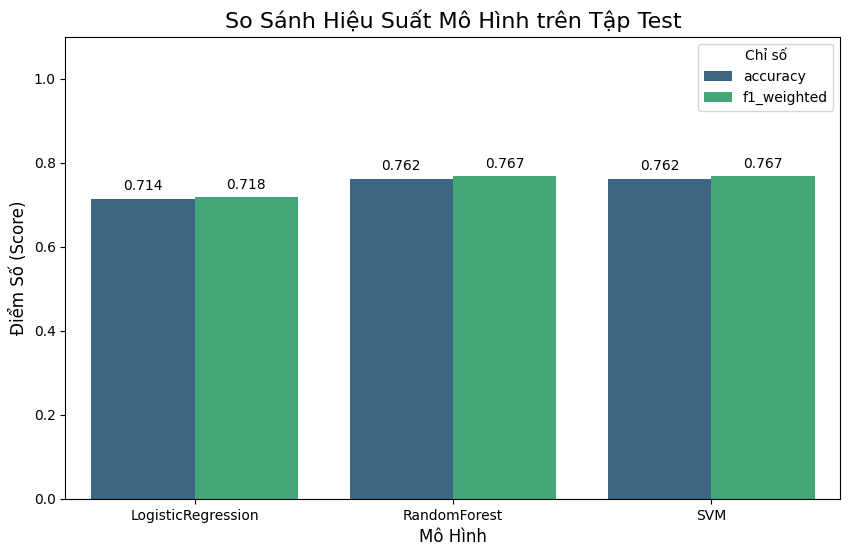

In [69]:
# Trực quan hóa kết quả từ 'model_results'

print("\n--- Biểu Đồ So Sánh Hiệu Suất Mô Hình (trên Tập Test) ---")
if model_results:
    df_results = pd.DataFrame(model_results)
    
    # Chuyển đổi dữ liệu từ dạng "wide" sang "long" để Seaborn vẽ
    df_melted = df_results.melt(id_vars='name', var_name='Metric', value_name='Score')
    
    plt.figure(figsize=(10, 6))
    sns.barplot(x='name', y='Score', hue='Metric', data=df_melted, palette='viridis')
    
    plt.title('So Sánh Hiệu Suất Mô Hình trên Tập Test', fontsize=16)
    plt.xlabel('Mô Hình', fontsize=12)
    plt.ylabel('Điểm Số (Score)', fontsize=12)
    plt.ylim(0.0, 1.1) # Đặt trục Y từ 0 đến 1.1 (để thấy số 1.0)
    plt.legend(title='Chỉ số')
    
    # Thêm số liệu lên trên cột
    ax = plt.gca()
    for p in ax.patches:
        if p.get_height():
            ax.annotate(f'{p.get_height():.3f}', 
                        (p.get_x() + p.get_width() / 2., p.get_height()), 
                        ha='center', va='center', 
                        xytext=(0, 9), 
                        textcoords='offset points')
    

    # Hiển thị (nếu chạy trong môi trường có GUI)
    # plt.show() # Bỏ comment nếu bạn muốn cửa sổ biểu đồ tự động mở
else:
    print("Không có kết quả mô hình để vẽ biểu đồ.")


--- Báo cáo Đánh giá trên Tập Test (Dữ liệu gốc) ---
Mô hình TỐT NHẤT được chọn (dựa trên F1-score): RandomForest
Độ chính xác (Accuracy): 0.7619
F1-Score (Weighted): 0.7674

Báo cáo Phân loại (Classification Report):
              precision    recall  f1-score   support

     Correct       0.58      1.00      0.74         7
   Incorrect       1.00      0.64      0.78        14

    accuracy                           0.76        21
   macro avg       0.79      0.82      0.76        21
weighted avg       0.86      0.76      0.77        21



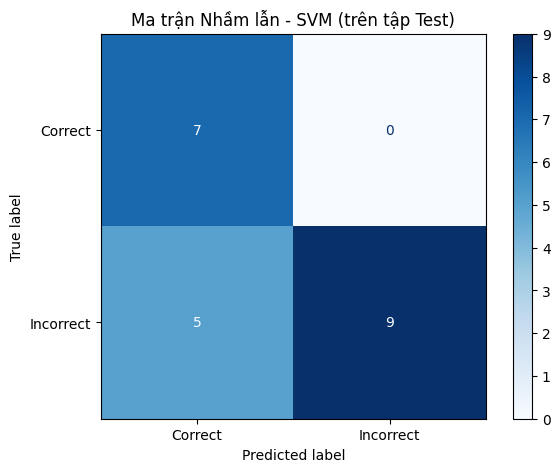

In [70]:
print("\n--- Báo cáo Đánh giá trên Tập Test (Dữ liệu gốc) ---")
best_model = best_estimators[best_model_name]

# Dự đoán trên tập test
y_pred_final = best_model.predict(X_test)

print(f"Mô hình TỐT NHẤT được chọn (dựa trên F1-score): {best_model_name}")
print(f"Độ chính xác (Accuracy): {accuracy_score(y_test, y_pred_final):.4f}")
print(f"F1-Score (Weighted): {f1_score(y_test, y_pred_final, average='weighted'):.4f}")

print("\nBáo cáo Phân loại (Classification Report):")
print(classification_report(y_test, y_pred_final, target_names=encoder.classes_))

fig, ax = plt.subplots(figsize=(7, 5))
ConfusionMatrixDisplay.from_estimator(
    best_model,
    X_test,
    y_test,
    display_labels=encoder.classes_,
    cmap=plt.cm.Blues,
    ax=ax
)
ax.set_title(f"Ma trận Nhầm lẫn - {name} (trên tập Test)")
plt.show()

In [71]:
# Lưu mô hình tốt nhất vào tệp .joblib để app.py sử dụng

print(f"\nLưu mô hình tốt nhất ({best_model_name}) vào: {MODEL_OUTPUT_PATH}")
joblib.dump(best_model, MODEL_OUTPUT_PATH)

print("\n--- Script 2 Hoàn thành ---")


Lưu mô hình tốt nhất (RandomForest) vào: models\classification_model\bicep_curl_best_model.joblib

--- Script 2 Hoàn thành ---
